# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

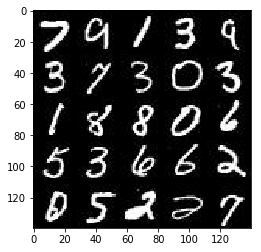

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

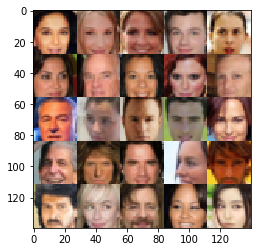

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out

    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 9.6888... Generator Loss: 0.0001
Epoch 1/2... Discriminator Loss: 0.0641... Generator Loss: 11.0601
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 1.4839
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 2.0795
Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 2.3934
Epoch 1/2... Discriminator Loss: 0.4026... Generator Loss: 1.7880
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 2.3245
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 2.8659


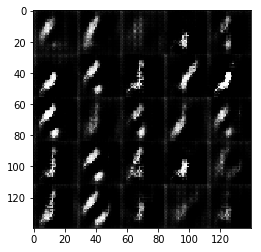

Epoch 1/2... Discriminator Loss: 0.4177... Generator Loss: 1.9138
Epoch 1/2... Discriminator Loss: 0.3701... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 2.2468... Generator Loss: 8.1906
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.2167
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.1249
Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 2.4104
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 6.3947
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.8712


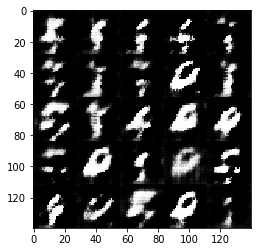

Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 1.8290
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 0.7846... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 2.7071
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.0422
Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 2.0076... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 2.1770
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 1.7458


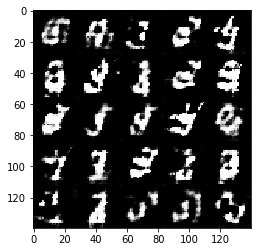

Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 2.8343
Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 2.2133
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 1.3314
Epoch 1/2... Discriminator Loss: 0.7033... Generator Loss: 2.0902
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 2.2045
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 0.3309
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.9013


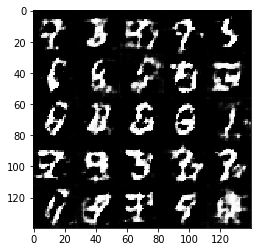

Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 2.3653
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.6051
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 0.6909... Generator Loss: 1.4525
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 1.3532
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 2.7855
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.7695
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 1.4509


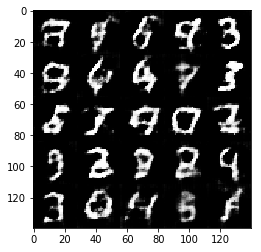

Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.2931
Epoch 1/2... Discriminator Loss: 1.6954... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 2.2123
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 3.1048
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 1.4578
Epoch 1/2... Discriminator Loss: 0.8005... Generator Loss: 1.4033
Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 1.4112


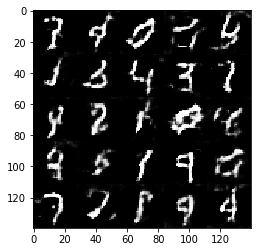

Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 3.5718
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.3103
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 5.1428... Generator Loss: 6.9799
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.2524


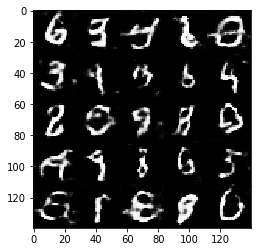

Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 2.3167
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 2.1025
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 1.6262... Generator Loss: 0.2969
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 1.1734
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.9334


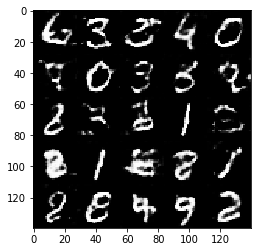

Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 2.0023
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 1.3404
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 1.6495
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 0.9109... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 2.7205... Generator Loss: 3.6686
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.7347


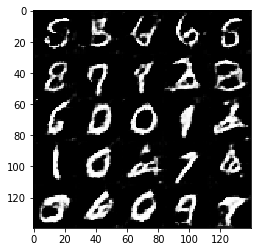

Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 1.2858
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.6176
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.6475
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.6346
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.5008


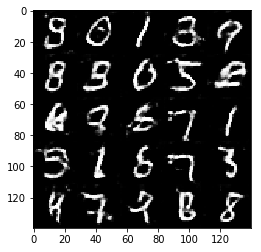

Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.5028
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.4246
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.2776
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.5435
Epoch 2/2... Discriminator Loss: 1.8331... Generator Loss: 3.2179
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.2315
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 0.7749


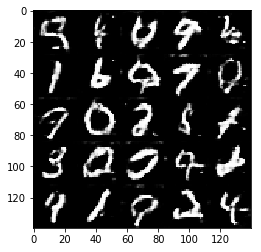

Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 2.0682... Generator Loss: 0.2556
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 2.3574... Generator Loss: 3.6772
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.4932
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.5717
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.3544
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.2325
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.6297


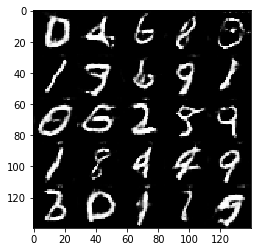

Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.1730... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.0210


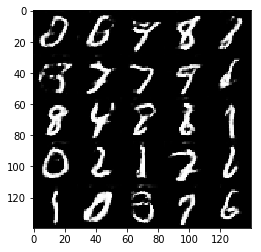

Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 2.0209... Generator Loss: 0.2017
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.0846... Generator Loss: 1.7020
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 2.6843
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 2.5992
Epoch 2/2.

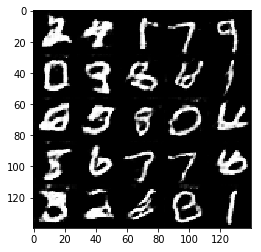

Epoch 2/2... Discriminator Loss: 1.8423... Generator Loss: 0.3639
Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.8596
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 1.7394
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.6351
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.5293


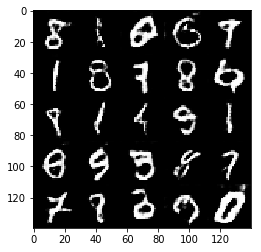

Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 1.7257
Epoch 2/2... Discriminator Loss: 2.1058... Generator Loss: 0.2063
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.4752
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 1.6304... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 0.9130
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.4975
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.5286


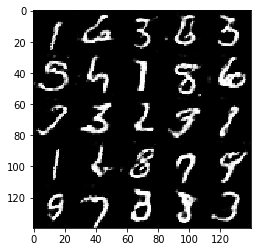

Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.5225
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.4449
Epoch 2/2... Discriminator Loss: 0.6386... Generator Loss: 1.6356
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 2.9811
Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 2.0084
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.7483
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.7276
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 2.2019... Generator Loss: 0.2163
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.8495


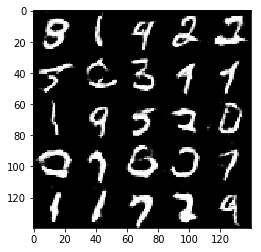

Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 0.2546... Generator Loss: 2.7254
Epoch 2/2... Discriminator Loss: 0.6593... Generator Loss: 1.7987
Epoch 2/2... Discriminator Loss: 2.4296... Generator Loss: 0.2106
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.1526


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.2682... Generator Loss: 0.0021
Epoch 1/1... Discriminator Loss: 1.7435... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 2.7111... Generator Loss: 0.1583
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.6826
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 6.3755
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 2.8295
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 3.4010
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 4.6297
Epoch 1/1... Discriminator Loss: 1.7600... Generator Loss: 6.6937
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.0261


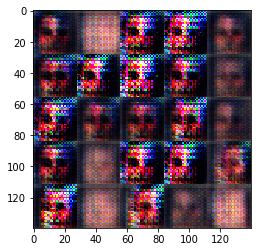

Epoch 1/1... Discriminator Loss: 0.1427... Generator Loss: 4.9327
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 2.8332
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 2.4301
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.8277
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 1.9124
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.4458


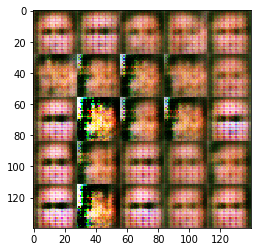

Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 1.5554
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 2.0147
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.6486
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.4146


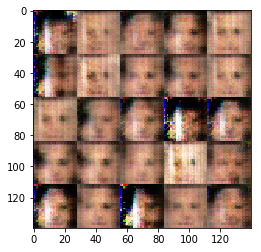

Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.0291
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 1.9320
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 1.9424... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 1.0310


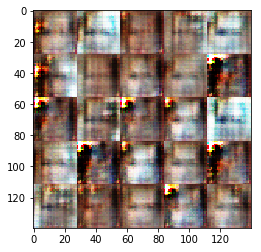

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0843


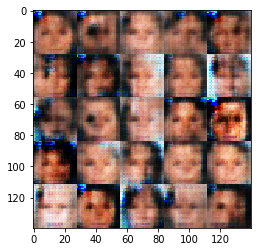

Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 2.0815... Generator Loss: 0.2133
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 2.0949
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0297


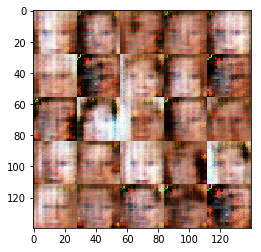

Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 2.0042... Generator Loss: 0.2954
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.2726


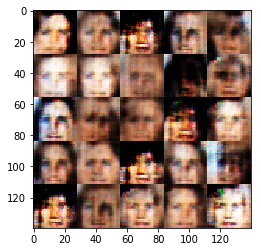

Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.6338


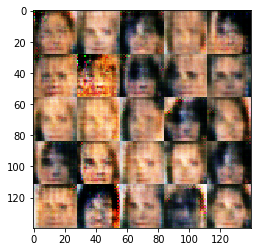

Epoch 1/1... Discriminator Loss: 1.7839... Generator Loss: 0.3256
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 2.3491
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 2.6328... Generator Loss: 0.1331


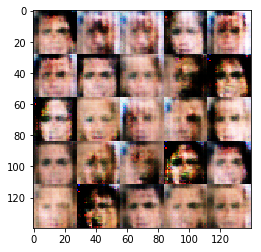

Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 2.7316
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.7814
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 1.9624... Generator Loss: 3.4538
Epoch 1/1... Discriminator Loss: 1.8299... Generator Loss: 2.6251
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7748


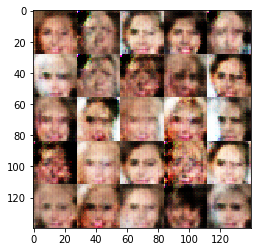

Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.8240


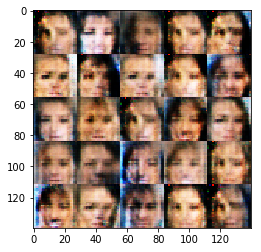

Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 2.0651
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9820


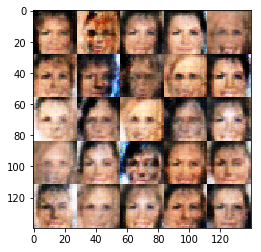

Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 1.5912


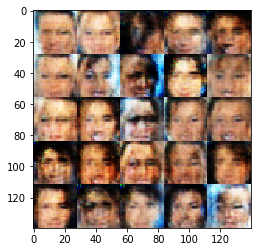

Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.7645... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.8062


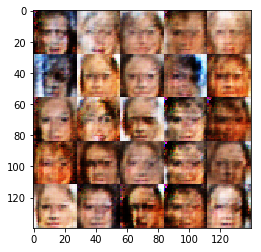

Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.7643... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.5104
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.8322


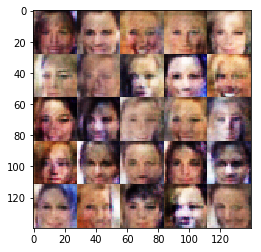

Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.5594
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 2.1671


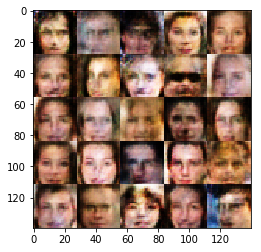

Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 2.3709
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 2.3351
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.5334
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.4788


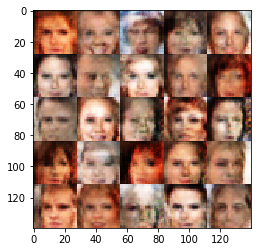

Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.4413
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.6927


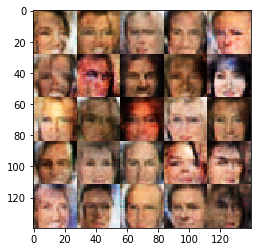

Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 2.3756
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 2.7292
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 2.8004


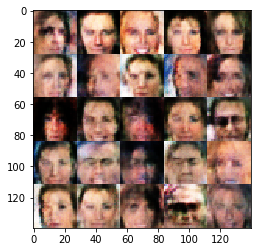

Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.4497
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.3748
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.1381


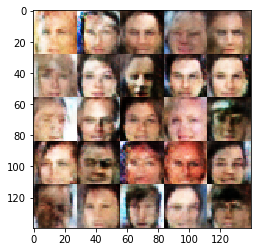

Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.6818... Generator Loss: 0.2898
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 2.2553
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.4037


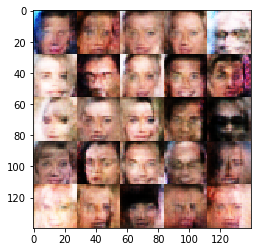

Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.7525
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.3694


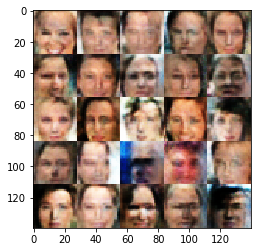

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.5337
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.0196


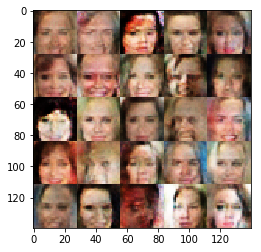

Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.5803
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.5517


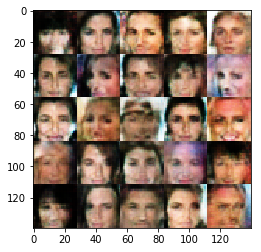

Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7165


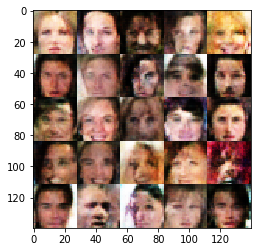

Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.9085
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0180


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.